In [ ]:
# Import libraries, use Google Colab 

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pathlib
import PIL
import PIL.Image

In [ ]:
# use GPU 
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
# dir of images train and test
# datset is a file .zip

images_train = os.path.join(final, 'dataset/train/')
images_test = os.path.join(final, 'dataset/test/')

train_dir = pathlib.Path(images_train)
test_dir = pathlib.Path(images_test)

# check if was extrated correctly
image_count = len(list(train_dir.glob('anger/*.png')))
print(image_count)

In [ ]:
# show the first image
disgusto = list(train_dir.glob('anger/*.png'))
PIL.Image.open(str(disgusto[0]))

In [ ]:
# show the first image test set
disgusto = list(test_dir.glob('anger/*.png'))
PIL.Image.open(str(disgusto[0]))

In [ ]:
import cv2

# categories from dataset
categories = {'anger':0,
              'disgust':1,
              'fear':2,
              'happy':3,
              'sadness':4,
              'surprise':5
              }


def get_data(root_path_images):

    # lists to store data
    data = []
    label = []

    # folder where data is placed
    BASE_FOLDER = root_path_images + '/'
    folders = os.listdir(BASE_FOLDER)

    
    # loading data to lists
    for folder in folders:
        for file in os.listdir(BASE_FOLDER + folder + '/'):
            img = cv2.imread(BASE_FOLDER + folder + '/' + file)
            
            # do any pre-processing if needed like resize, sharpen etc.
            data.append(img)
            label.append(categories[folder])
    
    
    return data, label

In [ ]:
# get dataset end labels
X, y = get_data(images_train)

print("Images of train\n")
print("train_data = {}\ntest_data = {}\n".format(len(X),len(y)))
print("\n\n")


In [ ]:
# images and lables, test data

X_testing, y_testing = get_data(images_test)
print("Images of train\n")
print("train_data = {}\ntest_data = {}\n".format(len(X_testing),len(y_testing)))
print("\n\n")
              


In [ ]:
# reshape the dim(32,32,3) -> (32,32,1)

def rgb2gray(rgb, reshape=None):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

def resized_RGB_to_Grayscale(X):
    
    X_ = []
    for image in X:
        gray = rgb2gray(image)
        gray = gray.reshape((32,32,1))
        X_.append(gray)

    return X_


# reshape all dataset
X_reshaped = resized_RGB_to_Grayscale(X)

In [ ]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split


NUM_CLASSES = 6
TEST_SIZE = 0.1

X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y,
                                                    test_size=TEST_SIZE,
                                                    random_state=44000)

X_train = np.asarray(X_train, dtype=np.float32)
X_test = np.asarray(X_test, dtype=np.float32)


# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
y_train = np.asarray(to_categorical(y_train, NUM_CLASSES), dtype=np.float32)
y_test = np.asarray(to_categorical(y_test, NUM_CLASSES), dtype=np.float32)





In [ ]:
print("Train samples:\nX = {}\ny = {}".format(X_train.shape, y_train.shape))
print("\nTest samples:\nX = {}\ny = {}".format(X_test.shape, y_test.shape))

# **Show images**

In [ ]:
# show random images from test
def show_images(images, labels):
    cols = 8
    rows = 2
    fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))

    for i in range(cols):
        for j in range(rows):
            
            random_index = np.random.randint(0, len(images))
            ax = fig.add_subplot(rows, cols, i * rows + j + 1)
            ax.grid('off')
            ax.axis('off')
            ax.imshow(images[random_index])
            
            cat = list(categories.keys())
            val = labels[random_index]
            ax.set_title(cat[val])

    plt.show()

In [ ]:
# show random images train

show_images(X, y)

In [ ]:
from keras import backend as K
import keras

# save the accuracy per epoch and val_accuracy, callback
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.val_acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))

# **Generating the model**

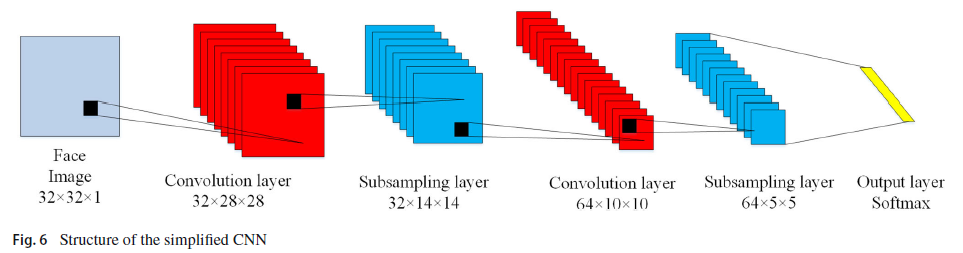

In [ ]:
# generating the model
import tensorflow as tf
from keras import layers
from keras import models
from keras import initializers
 

def cnn_model():

    # define a sequential model
    model = models.Sequential()
    initializer = tf.initializers.GlorotUniform()

    # 1st conv layer
    model.add(layers.Conv2D(32, (5, 5),
                            activation='relu',
                            kernel_initializer = initializer,
                            input_shape=(32, 32, 1)))
    
    # 1st maxpooling layer
    model.add(layers.MaxPooling2D(pool_size=(2, 2),
                                  strides=2))
    
    
    

    # 2nd conv layer
    model.add(layers.Conv2D(64, (5, 5),
                            activation='relu',
                            kernel_initializer = initializer))
    
    # 2nd maxpooling layer
    model.add(layers.MaxPooling2D(pool_size=(2, 2),
                                  strides=2))
    ##dropout
    model.add(layers.Dropout(0.5))
    

    model.add(layers.Flatten())

    
    # layer out
    model.add(layers.Dense(NUM_CLASSES,
                           activation='softmax'))

    return model



In [ ]:
# red, 61,702
model = cnn_model()
model.summary()

# K-fold [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html)




In [ ]:
from sklearn.model_selection import KFold

# k-folds
num_folds = 10


# Merge inputs and targets
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

In [ ]:
len(inputs)

In [ ]:
import matplotlib.pyplot as plt

# plot the metrics during training, callbacks
def plot_metrics(train_log):

    plt.plot(train_log.history['acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()


def plot_acc(train_log):
     
    acc = train_log.history['acc']
    loss = train_log.history['loss']

    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'r', label='Training acc')

    plt.legend()
    plt.figure()

    plt.show()



#  [**Data Augmentation**](https://www.tensorflow.org/tutorials/images/data_augmentation)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator


def data_aug(X_train, X_test, train_batch_size):

    train_datagen = ImageDataGenerator(
        rotation_range=2,
        horizontal_flip=True)
    
    
    train_batch = train_datagen.flow(X_train, y_train, batch_size=train_batch_size)
    
    
    return train_batch




# **Train the dataset applying ten-fold and data augmentation during training**

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops
from tensorflow.python.training import optimizer
from tensorflow.python.training import training_ops
from tensorflow.python.util.tf_export import tf_export


@tf_export(v1=["train.MomentumOptimizer"])
class MomentumOptimizer(optimizer.Optimizer):

    """Optimizer that implements the Momentum algorithm.
  Computes (if `use_nesterov = False`):
  ```
  accumulation = momentum * accumulation + gradient
  variable -= learning_rate * accumulation
  ```
  Note that in the dense version of this algorithm, `accumulation` is updated
  and applied regardless of a gradient's value, whereas the sparse version (when
  the gradient is an `IndexedSlices`, typically because of `tf.gather` or an
  embedding) only updates variable slices and corresponding `accumulation` terms
  when that part of the variable was used in the forward pass.
  """

    def __init__(self, learning_rate, momentum,
               use_locking=False, name="Momentum", use_nesterov=False):
    """Construct a new Momentum optimizer.
    Args:
      learning_rate: A `Tensor` or a floating point value.  The learning rate.
      momentum: A `Tensor` or a floating point value.  The momentum.
      use_locking: If `True` use locks for update operations.
      name: Optional name prefix for the operations created when applying
        gradients.  Defaults to "Momentum".
      use_nesterov: If `True` use Nesterov Momentum.
        See (Sutskever et al., 2013).
        This implementation always computes gradients at the value of the
        variable(s) passed to the optimizer. Using Nesterov Momentum makes the
        variable(s) track the values called `theta_t + mu*v_t` in the paper.
        This implementation is an approximation of the original formula, valid
        for high values of momentum. It will compute the "adjusted gradient"
        in NAG by assuming that the new gradient will be estimated by the
        current average gradient plus the product of momentum and the change
        in the average gradient.
    References:
      On the importance of initialization and momentum in deep learning:
        [Sutskever et al., 2013]
        (http://proceedings.mlr.press/v28/sutskever13.html)
        ([pdf](http://proceedings.mlr.press/v28/sutskever13.pdf))
    @compatibility(eager)
    When eager execution is enabled, `learning_rate` and `momentum` can each be
    a callable that takes no arguments and returns the actual value to use. This
    can be useful for changing these values across different invocations of
    optimizer functions.
    @end_compatibility
    """
    super(MomentumOptimizer, self).__init__(use_locking, name)
    self._learning_rate = learning_rate
    self._momentum = momentum
    self._use_nesterov = use_nesterov

    def _create_slots(self, var_list):
        for v in var_list:
            self._zeros_slot(v, "momentum", self._name)

    def _prepare(self):
    learning_rate = self._learning_rate
    if callable(learning_rate):
        learning_rate = learning_rate()
    self._learning_rate_tensor = ops.convert_to_tensor(learning_rate,
                                                       name="learning_rate")
    momentum = self._momentum
    if callable(momentum):
        momentum = momentum()
    self._momentum_tensor = ops.convert_to_tensor(momentum, name="momentum")

    def _apply_dense(self, grad, var):
    mom = self.get_slot(var, "momentum")
    return training_ops.apply_momentum(
        var, mom,
        math_ops.cast(self._learning_rate_tensor, var.dtype.base_dtype),
        grad,
        math_ops.cast(self._momentum_tensor, var.dtype.base_dtype),
        use_locking=self._use_locking,
        use_nesterov=self._use_nesterov).op

    def _resource_apply_dense(self, grad, var):
        mom = self.get_slot(var, "momentum")
        return training_ops.resource_apply_momentum(
            var.handle, mom.handle,
            math_ops.cast(self._learning_rate_tensor, grad.dtype.base_dtype),
            grad,
            math_ops.cast(self._momentum_tensor, grad.dtype.base_dtype),
            use_locking=self._use_locking,
            use_nesterov=self._use_nesterov)

    def _apply_sparse(self, grad, var):
        mom = self.get_slot(var, "momentum")
        return training_ops.sparse_apply_momentum(
            var, mom,
            math_ops.cast(self._learning_rate_tensor, var.dtype.base_dtype),
            grad.values, grad.indices,
            math_ops.cast(self._momentum_tensor, var.dtype.base_dtype),
            use_locking=self._use_locking,
            use_nesterov=self._use_nesterov).op

    def _resource_apply_sparse(self, grad, var, indices):
        mom = self.get_slot(var, "momentum")
        return training_ops.resource_sparse_apply_momentum(
            var.handle, mom.handle,
            math_ops.cast(self._learning_rate_tensor, grad.dtype),
            grad, indices,
            math_ops.cast(self._momentum_tensor, grad.dtype),
            use_locking=self._use_locking,
            use_nesterov=self._use_nesterov)

    

In [ ]:
from keras import optimizers


NO_EPOCHS = 120
BATCH_SIZE = 16
NUM_FOLDS = 10
INIT_LR = 1e-3


 # define per-fold score containers
ACC_PER_FOLD = []
LOSS_PER_FOLD = []


# actual fold
fold_no = 1

for train, test in kfold.split(inputs, targets):

    tf.keras.backend.clear_session()

    # generate a new model
    network = cnn_model()

    history = AccuracyHistory()

    # compile model    
    optimizer = MomentumOptimizer(learning_rate=INIT_LR, momentum=0.9, use_nesterov=True)
    network.compile(loss='categorical_crossentropy', 
                    optimizer=optimizer,
                    metrics=['acc'])

    print('-*'*70)
    print(f'==> Training for fold {fold_no}/{NUM_FOLDS} <==')
    

    # save the weights per fold
    checkpoint_path = 'your_path/' + "model_weights_" + str(fold_no) + '.h5'

    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                      save_weights_only=True,
                                                      verbose=1)

    #data augmentation during training
    datagen = ImageDataGenerator(
        rotation_range=2,
        horizontal_flip=True)


    X_train = inputs[train]
    y_train = targets[train]

    X_val = inputs[test]
    y_val = targets[test]

    # fit data to model
    with tf.device('/device:GPU:0'):

        traing_log = network.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                                 validation_data=(X_val, y_val),
                                 shuffle=True,
                                 epochs=NO_EPOCHS,
                                 callbacks=[history])# add 'checkpointer' to save the weights
        

    # plot the metrics
    plot_metrics(traing_log)

    # Generate generalization metrics
    scores = network.evaluate(X_val, y_val, verbose=0)
    print(f'\n*** Score for fold {fold_no}: {network.metrics_names[0]} of {scores[0]}; {network.metrics_names[1]} of {scores[1]*100}%')
    ACC_PER_FOLD.append(scores[1] * 100)
    LOSS_PER_FOLD.append(scores[0])
    print("\n")

    fold_no += 1
    
    



In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')

for i in range(0, len(ACC_PER_FOLD)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {LOSS_PER_FOLD[i]} - Accuracy: {ACC_PER_FOLD[i]}%')

print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(ACC_PER_FOLD)} (+- {np.std(ACC_PER_FOLD)})')
print(f'> Loss: {np.mean(LOSS_PER_FOLD)}')
print('------------------------------------------------------------------------')


**Load and test the model**

In [ ]:
from keras.utils import to_categorical

NUM_CLASSES = 6

images_test = resized_RGB_to_Grayscale(X_testing)
images_test = np.asarray(images_test, dtype=np.float32)

labels_test = np.asarray(to_categorical(y_testing, NUM_CLASSES), dtype=np.float32)

In [ ]:
(labels_test.shape, images_test.shape)

In [ ]:
# weights

from sklearn.metrics import classification_report


best = 0
fold = 0

for i in range(1,11):
    weights = "your_path/model_weights_" + str(i) + ".h5"
    # Create a new model instance
    model = cnn_model()

    optimizer = MomentumOptimizer(learning_rate=0.001, momentum=0.9, use_nesterov=True)
    model.compile(loss='categorical_crossentropy', 
                    optimizer=optimizer,
                    metrics=['acc'])


    # Restore the weights
    model.load_weights(weights)
    

    # Evaluate the model
    loss, acc = model.evaluate(images_test, labels_test, verbose=2)
    value = 100 * acc
    pred = model.predict(images_test, verbose=2)
    predicted = np.argmax(pred, axis=1)
    report = classification_report(np.argmax(labels_test, axis=1), predicted)
    
    print(report)
    print("Fold {}, Restored model, accuracy: {:5.2f}%".format(i, value))
    
    if value > best:
        best = value
        fold = i
    print("---"*30)

print("the best fold {} result is {}".format(fold, best))


